# GEOG0027 (2021/2022) Classification with Google Earth Engine (GEE)


following one from the previous tutorial, this notebook is a bare-bones processing loop

In [2]:
import geemap, ee, os, numpy
import ipyleaflet

Map = geemap.Map(center=[22.634, 114.19], zoom=9)
Map

Map(center=[22.634, 114.19], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [3]:
shenzhen_rec = ee.Geometry.Rectangle([113.7659, 22.40, 114.6654, 22.8536]) 

## Select 'Shenzhen' as the area of interest (AOI)
The vector border layer is imported from https://developers.google.com/earth-engine/datasets/tags/borders, which includes the [Global Administrative Unit Layers (GAUL) data](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2) from 2015. You may notice that Shenzhen's boundary has expanded since (e.g. coastal landfill). We can, for example, manually draw/define another polygon and clip it to the GAUL border file, or, as a simple example, we will add a 'buffer' (e.g. 3000 meters) to the GAUL boundary data. This inevitably will introduce some areas outside the border of Shenzhen, e.g. part of Hong Kong, so you can work out some more elegant way of combining/clipping multiple AOI layers if time allows. Please justify your choice and summarize how you made it in the report. In the following example, I will use the `shenzhen_buffer` as my AOI.

In [4]:
cities = ee.FeatureCollection("FAO/GAUL/2015/level2")
#Map.addLayer(cities, {}, 'Cities', False)

shenzhen = cities.filter(ee.Filter.eq('ADM2_NAME', 'Shenzhen'))
outline = ee.Image().byte().paint(**{
  'featureCollection': shenzhen,
  'color': 1,
  'width': 3
})
Map.addLayer(outline, {}, 'Shenzhen')

# Next, add some buffer to include the coastal expansion areas
shenzhen_buffer = ee.Geometry(shenzhen.geometry()).buffer(3000)
Map.addLayer(shenzhen_buffer, {}, 'Buffer around Shenzhen')
#Map.addLayer(rec, "Original rec bounds")
#Map

## Load Landsat data collections from GEE
Now we can see the the buffered AOI displayed on the Map. Next, let's load some Landsat images for the Shenzhen area. I've defined here a python function called `display_landsat_collection` to do so. It automatically loads both the [surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR) and [annual NDVI](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_ANNUAL_NDVI) image collections from GEE's data catalog and also calculates the annual means for each band. 

You can skip most of the details of what's inside the code cell, but only to look at the first (and last) line of code. In order to run such function, you will need to choose a year (any year since 1984) and an AOI. In the following example, I choose year 2019 and the Shenzhen buffer to demonstrate the use of the code.

In [5]:
landsat_vis_param = {
            'min': 0,
            'max': 3000,
            'bands': ['NIR', 'Red', 'Green']  # False Colour Composit bands to be visualised 
}
ndvi_colorized_vis = {
            'min': 0.0,
            'max': 1.0,
            'palette': [
            'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
            '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
            '012E01', '011D01', '011301']
}

def load_landsat_collection(year, aoi, cloud_tolerance = 3.0, 
                            DISPLAY_ON_MAP = False, MEDIAN_ONLY = False):
    '''This function allows GEE to display a Landsat data collection 
    from any year between 1984 and present year
    that fall within the AOI and cloud tolerance, e.g. 3.0%.
    There are two optional flag:
    When DISPLAY_ON_MAP is TRUE, display this layer onto Map;
    When return_series = 'MEDIAN_ONLY', only median SR is loaded into landsat_ts, and
    Setting this option to MEDIAN_ONLY would be faster than loading other collections. 
    '''
    assert year >= 1984
    
    def renameBandsETM(image):
        if year >=2013: #LS8
            bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'] #, 'pixel_qa'
            new_bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'] #, 'pixel_qa'
        elif year <=1984:
            bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa']
            new_bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa']
        else:
            bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
            new_bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
        return image.select(bands).rename(new_bands)
        
    if not(MEDIAN_ONLY):
        if year >= 2013:
            layer_name = 'LC08' # LS8: 2013-now        
        elif year == 2012: # # LS7: 1999- , however SLC error >= 1999:
            layer_name = 'LE07' 
        elif year >=1984:
            layer_name = 'LT05' # LS5: 1984-2012
       
        collection_name_sr = f"LANDSAT/{layer_name}/C01/T1_SR" 
        # You can also use the following line, if interested in incorperating ndvi
        collection_name_ndvi = f"LANDSAT/{layer_name}/C01/T1_ANNUAL_NDVI" 

        all_sr_image = ee.ImageCollection(collection_name_sr) \
            .filterBounds(aoi) \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_tolerance))\
            .sort('system:time_start') \
            .select('B[1-7]') \
            .sort('CLOUD_COVER')

        all_sr_image = all_sr_image.map(renameBandsETM) # rename bands with 'renameBandsETM' function
        
        # reduce all_sr_image to annual average per pixel
        mean_image = all_sr_image.mean()
        mean_image = mean_image.clip(aoi).unmask()

        ndvi_image = ee.ImageCollection(collection_name_ndvi)\
            .filterBounds(aoi) \
            .filterDate(f'{year}-01-01', f'{year}-12-31')\
            .select('NDVI')\
            .first()
        ndvi_image = ndvi_image.clip(aoi).unmask()

        #mean_image.addBands(ndvi_image, 'NDVI')
    
    # This line loads all annual median surface ref
    landsat_ts = geemap.landsat_timeseries(roi=shenzhen_buffer, start_year=year, end_year=year, \
                                       start_date='01-01', end_date='12-31')

    median_image = landsat_ts.first().clip(aoi).unmask()
    
    if DISPLAY_ON_MAP == True:
        
        if not(MEDIAN_ONLY):
            Map.addLayer(ndvi_image, ndvi_colorized_vis, 'NDVI '+str(year),  opacity=0.9)
            Map.addLayer(mean_image, landsat_vis_param, "Mean Ref "+str(year))
        Map.addLayer(median_image, landsat_vis_param, "Median Ref "+str(year))

    if MEDIAN_ONLY:
        return median_image
    else:
        return all_sr_image, mean_image, median_image, ndvi_image 

Now the `load_landsat_collection` function has been defined, and we will run/execute it by calling the function name with appropriate input parameters (or 'arguments). The output of such function will be returned to the variables on the LHS of the equal sign, i.e. all_image_2019, mean_2019, median_2019, and ndvi_2019 in this case.

In [6]:
Map = geemap.Map(center=[22.634, 114.19], zoom=10)

# All you need to modify here is the YEAR below:
all_image, mean, median, ndvi = load_landsat_collection(2011,\
                                        shenzhen_buffer, cloud_tolerance = 3,\
                                        DISPLAY_ON_MAP = True)
Map

Map(center=[22.634, 114.19], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [14]:
mean_ndvi = mean_2019.normalizedDifference(['NIR', 'Red'])
median_ndvi = median_2019.normalizedDifference(['NIR', 'Red'])
median_ndwi = median_2019.normalizedDifference(['Green','NIR'])

Map.addLayer(median_ndwi, ndvi_colorized_vis, 'NDWI from Median LS')
Map.addLayer(median_ndwi, ndvi_colorized_vis, 'NDWI from Median LS')
Map

Map(bottom=57459.0, center=[22.350753194819696, 113.60549926757814], controls=(WidgetControl(options=['positio…

In [53]:
legend_colors = ['#1ED760', '#601ED7', '#D7601E','#D71E39', '#1E39D7']
def unsupervised_classifier(image, aoi, year, n_clusters=5, output_filename='', DISPLAY_ON_MAP = False):
    '''This function provides a simple K-means classifier,
    with a default no. of cluster of 5. User will need to specify 
    an AOI and an image to be classified.
    Optional arguments:
    n_clusters defines the number of clusters in the K-means classifier;
    output_filename should be a quoted string, e.g. 'Shenzhen_Landsat_Kmeans_2019.tif';
    DISPLAY_ON_MAP can be switched on, so the cluster map will be added to Map.
    '''
    
    # Make the training dataset:
    training_points = image.sample(**{
        'region': aoi,
        'scale': 30,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })

    #Map.addLayer(training_points, {}, 'training points', False) # No need to visualise this layer

    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training_points)

    # Cluster the input using the trained clusterer.
    class_result = image.cluster(clusterer)
    
    # Reclassify the map to avoid zero, in case of masking. E.g. from [0, 1, 2, 3, 4] to [1, 2, 3, 4, 5]
    #class_result = class_result.remap(list(range(0, n_clusters)), list(range(1, n_clusters+1)))

    if DISPLAY_ON_MAP:
        # Display the clusters with random colors.
        Map.addLayer(class_result, {'min': 0, 'max': 4,'palette': legend_colors}, 'Clusters '+str(year))

    if output_filename == '':
        print(f'{year} classification finished. No output exported.')
    else:
        #Export the result directly to your computer/Hub:
        geemap.ee_export_image(class_result, filename=output_filename, \
                            scale=900, region=aoi, file_per_band=False) 
        # When scale is small, GEE won't allow downloading due to size limitation

    return class_result

The above cell only 'defines' a function but does NOT execute it, so we now need to actually run it by calling the function name with appropriate arguments:

The number of clusters to use depends on the image, and it may different between different years. For the 2019 example, we used 5 clusters and the results seem to include two 'Urban' and two 'Vegetation' clusters. In such situation, we may consider grouping multiple clusters together, by re-mapping the cluster numbers:

However, sometimes you may find the reclustered results less satisfactory, so consider carefully before executing the re-mapping code. 

After remapping the clusters, we have just three final classes now.  Would this be the same as if we ran the `unsupervised_classifier` function with `n_clusters = 3`? Have a try. 

## Cluster areas
Next, we need to find out the size of each cluster, i.e. how many pixels belong to each class, and the total size of each class (hint: how big is each pixel?)

In [11]:
def calculate_class_size(class_result, year, legend_keys, PRINT_STATS=False):
    n_clusters = len(legend_keys)
    
    #landsat_stats = geemap.image_stats(class_result, scale=90)
    #print(landsat_stats.getInfo())

    if year in [2000, 2004]: 
        print(f'Downscaling for year {year}')
        scale_factor= 3
    else: scale_factor= 1
    
    stats = {'Year': year}
    for i in range(n_clusters):
        remap = numpy.zeros(n_clusters)
        remap[i] = 1
        class_0 = class_result.remap(list(range(0, n_clusters)), list(remap))
        #print(list(remap))
        class_stats0 = geemap.image_stats(class_0, scale=30*scale_factor)
        #print(class_stats0.getInfo())
        
        sum_class0 = class_stats0.getInfo()['sum']
        sum_clean = int(sum_class0['remapped'])
        if PRINT_STATS:
            print(legend_keys[i], 'has', sum_clean, 'pixles.')
        stats[legend_keys[i]] = sum_clean * (scale_factor**2)
        
    return stats

These are the numbers we will need for the R modeling. We will also show you how to export these values automatically later. But for now, have another close examination of the classification results and the functions we used to generated them. 

## Repeat for multiple years
By now, you should be able to understand that the `load_landsat_collection` function allows us to just vary the 'year' variable (and leave AOI and Cloud Tolerance constant) to loop through a time series of data. Similarly, for the `unsupervised_classifier` function, we can vary the input 'image' variable (an output from the `load_landsat_collection` function) in order to classify multiple images. Below is a loop built for running K-means classification for Landsat time series for the Shenzhen area. Years between 1987 to 2016 are selected to match our socio-economic data. When this cell is running (you can spot a star key on the LHS of the cell), you can track the progress by looking at the output messages. Once the cell finished running, an integer number will be shown outside of the LHS of the cell, and you can examine the layers in the Map (if DISPLAY_ON_MAP flag was set to True)

## Note comment out/in using a '#'  symbol to use the bits of code you want.

In [71]:
## new map for loop
Map = geemap.Map(center=[22.634, 114.19], zoom=9)
cluster_pixels = []

# Only to demonstrate every 10 years, but you should run every year, ideally in groups
# for year in range(1986, 2017, 10): 
### for a set number of years
for year in range(2002, 2006, 1): 
    
    #### median only
    median_image = load_landsat_collection(year, shenzhen_buffer, cloud_tolerance=3,\
                                          MEDIAN_ONLY = True)
    class_result = unsupervised_classifier(median_image, shenzhen_buffer, year,\
                    n_clusters=5, DISPLAY_ON_MAP = True) #output_filename=f'Shenzhen_Landsat_Kmeans_{year}.tif'

#     #### all the options
#     all_image, mean, median, ndvi = load_landsat_collection(year, shenzhen_buffer, cloud_tolerance=3)
# #     ### classify using the mean
#     class_result = unsupervised_classifier(mean, shenzhen_buffer, year,\
#                     n_clusters=3, DISPLAY_ON_MAP = True) #output_filename=f'Shenzhen_Landsat_Kmeans_{year}.tif'
    
#     #### or use the ndvi
#     class_result = unsupervised_classifier(ndvi, shenzhen_buffer, year,\
#                     n_clusters=3, DISPLAY_ON_MAP = True) #output_filename=f'Shenzhen_Landsat_Kmeans_{year}.tif'
    
    ### remapping if you want
#     remapped_class_result = class_result.remap([0, 1, 2, 3, 4], [1, 2, 1, 3, 2])
    legend_keys = ['Class 1', 'Class 2', 'Class 3',  'Class 4', 'Class 5'] #change the class names
    
    ### next calculates the class sizes, this is the slow bit. So if you just want to look at them, comment out
#     stats = calculate_class_size(class_result, year, legend_keys)
#     cluster_pixels.append(numpy.fromiter(stats.values(), dtype=int))
#     if 'Urban' in stats: print(f'There are {int(stats["Urban"])} urban pixles in {str(year)}.')    
#     print(stats)

#Map

2002 classification finished. No output exported.
2003 classification finished. No output exported.
2004 classification finished. No output exported.
2005 classification finished. No output exported.


In [72]:
# legend_colors = ['#FFFFB3', '#8DD3C7', '#FFFFB0','#80B1D3', '#8DD3C0']
legend_colors = ['#1ED760', '#601ED7', '#D7601E','#D71E39', '#1E39D7']
Map.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
Map

Map(center=[22.634, 114.19], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

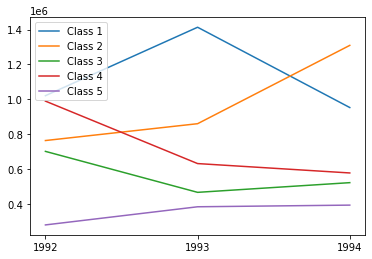

In [66]:
### plot classes
import matplotlib.pyplot as plt
plot_years = [cp[0] for cp in cluster_pixels]
for class_no in range(len(cluster_pixels[0])-1):
    plot_class = [cp[class_no+1] for cp in cluster_pixels]
    plt.plot(plot_years,plot_class,label=legend_keys[class_no])

plt.legend()
plt.xticks(plot_years)
plt.show()

After running the above loop of code to classify a time series, all cluster areas (i.e. pixel counts) have been recorded into the `cluster_pixels` variable, and cluster layers are mapped into the Map.

## Export results to excel (.csv) files
Lastly, we will use the following code to export the sizes of each class/cluster into a csv file, and you will need this file for R modeling in the next part of the coursework.

In [20]:
header = 'Year, ' + ', '.join( legend_keys )
numpy.savetxt("Shenzhen_pixel_stats.csv", cluster_pixels, delimiter=",", header=header)       

**Congratulations (on finishing the classification part)!**

So far, we have processed the entire time series of Landsat data without actually downloading any of them to our local PC (everything is done on the Cloud!), except the .CSV file. I hope you've enjoyed playing with GEE here. Now you should be able to open the CSV file in excel or R to continue with the [modeling part](https://github.com/qwu-570/GEOG0027_Coursework/blob/2020-2021/docs/6_UrbanModel.ipynb) of the coursework.